In [130]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal


In [131]:
# Read data file
data = pd.read_csv('data.txt',delim_whitespace=True)
x_1 = data['eruptions'].tolist()
x_2 = data['waiting'].tolist()
# Get features of the point out and stack them  into the sample data
sample_data = data[['eruptions', 'waiting']].to_numpy()
# cluster = np.zeros([272])

data


,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
...,...,...
268,4.117,81
269,2.150,46
270,4.417,90
271,1.817,46


### Problem (a)


/var/folders/ck/b09qsxz518x4rlt33mrt531c0000gn/T/ipykernel_11467/1405692069.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  p1 = plt.scatter(X, Y,edgecolor='k', s=60, cmap=plt.cm.Paired)


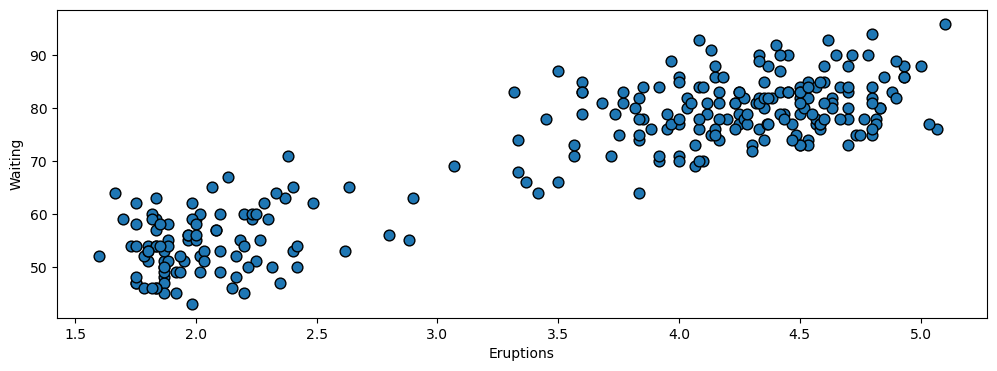

In [132]:
# Plot the picture
X,Y = data['eruptions'],data['waiting']
plt.rcParams['figure.figsize'] = [12, 4]
p1 = plt.scatter(X, Y,edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.show()

### Problem (b)
 Write the expression for $P_{\theta_t}(z = k | x)$:

$$
P_{\theta_{t}}(z=k \mid x)=\frac{P_{\theta_{t}}(z=k, x)}{P_{\theta_{t}}(x)}=\frac{P_{\theta_{t}}(z=k, x)}{\sum_{l=1}^{K} P_{\theta_{t}}(x \mid z=l) P_{\theta_{t}}(z=l)} .
$$

In [134]:
def Estep(X, mus, Sigmas, phis, K):
     n = X.shape[0]  
     pzx = np.zeros((K, n))  
     for k in range(K):  
         for i in range(n): 
             pxz = phis[k] * multivariate_normal.pdf(X[i], mean=mus[k], cov=Sigmas[k])
             px = sum(phis[j] * multivariate_normal.pdf(X[i], mean=mus[j], cov=Sigmas[j])
                       for j in range(K))
             pzx[k, i] = pxz / px
             clusters = np.argmax(pzx, axis=0)
     return pzx, clusters


### Problem (c)
Write down the formula for $\mu_k$ , $\Sigma_k$ , and for the parameters $\phi$ at the M-step (we have also seen
these formulas in class).

$$
\mu_k = \frac{\sum_{i=1}^{n} P(z = k|x^{(i)})x^{(i)}}{n_k}
$$
$$
\Sigma_{k} = \frac{\sum_{i=1}^{n} P(z = k|x^{(i)})(x^{(i)}-\mu_k)(x^{(i)}-\mu_k)^{T}}{n_k}
$$
$$
n_k = \sum_{i=1}^{n}P(z=k|x^{(i)})
$$


In [135]:
def Mstep(pzx, X, K, draw):
    n = X.shape[0]
    d = X.shape[1]  
    n_k = np.sum(pzx, axis=1)  
    mus = np.zeros((K, d))
    Sigmas = np.zeros((K, d, d))
    phis = np.zeros(K)
    
    
    for k in range(K):
        mus[k] = np.sum(pzx[k, :].reshape(-1, 1) * X, axis=0) / n_k[k]
        draw.append((f"mus{k}", mus[k])) 
        phis[k] = n_k[k] / n
        Sigmas[k] = np.sum([pzx[k, j] * np.outer(X[j] - mus[k], X[j] - mus[k]) 
                            for j in range(n)], axis=0) / n_k[k]
  
    return mus, Sigmas, phis, draw


### Problem (d)
1. Implement and run the EM algorithm.


In [136]:
def em_algorithm(X, K, max_iters=100, diff=1e-5):
    # Initialize the parameters
    n, d = X.shape
    indices = np.random.choice(n, K, replace=False)
    mus = X[indices]
    draw = [("mus0", mus[0]), ("mus1", mus[1])]
    Sigmas = np.array([np.eye(d) for _ in range(K)])
    phis = np.ones(K)/ K

    for iter in range(max_iters):
        pzx, clusters = Estep(X, mus, Sigmas, phis, K)
        old_mus = mus.copy() 
        mus, Sigmas, phis, draw = Mstep(pzx, X, K, draw)
        if np.linalg.norm(mus - old_mus) < diff:
            print(f"The EM algorithm converges at {iter} iterations.")
            break
    if np.linalg.norm(mus - old_mus) >= diff:
        print(f"The EM algorithm didn't converge at {max_iters} iterations.")

 

    return mus, Sigmas, phis, draw, clusters



2. The termination criterion is the difference of $ \mu_k $ between iterations. In the iteration process, if the mean of our assigned cluster doesn't change, it means that we have approximated the real cluster of assignments and the algorithm has converged. Thus, I chose the L-2 norm between old $\mu_k $ and new $ \mu_k $ to observe how far they moved between iterations. If this movement is very small, it indicates that my algorithm has converged. In my algorithm, I chose $1 \times 10^{-5}$ as the required difference.


In [137]:
mus, Sigmas, phis, draw, clusters = em_algorithm(sample_data, 2)
print(clusters)
print(sample_data)

The EM algorithm converges at 12 iterations.
[0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 1 0]
[[ 3.6   79.   ]
 [ 1.8   54.   ]
 [ 3.333 74.   ]
 [ 2.283 62.   ]
 [ 4.533 85.   ]
 [ 2.883 55.   ]
 [ 4.7   88.   ]
 [ 3.6   85.   ]
 [ 1.95  51.   ]
 [ 4.35  85.   ]
 [ 1.833 54.   ]
 [ 3.917 84.   ]
 [ 4.2   78.   ]
 [ 1.75  47.   ]
 [ 4.7   83.   ]
 [ 2.167 52.   ]
 [ 1.75  62.   ]
 [ 4.8   84.   ]
 [ 1.6   52.   ]
 [ 4.25  79.   ]
 [ 1.8   51.   ]
 [ 1.75  47.   ]
 [ 3.45  78.   ]
 [ 3.067 69

In [138]:
mus0_list = []
mus1_list = []

data = draw

for label, value in data:
    if label == "mus0":
        mus0_list.append(value)
    elif label == "mus1":
        mus1_list.append(value)

mus0_array = np.array(mus0_list)
mus1_array = np.array(mus1_list)



3. Plot the trajectories of the two mean vectors (μ1 and μ2) in two dimensions as they change over the course of running EM. You might want to use a scatter plot for this.

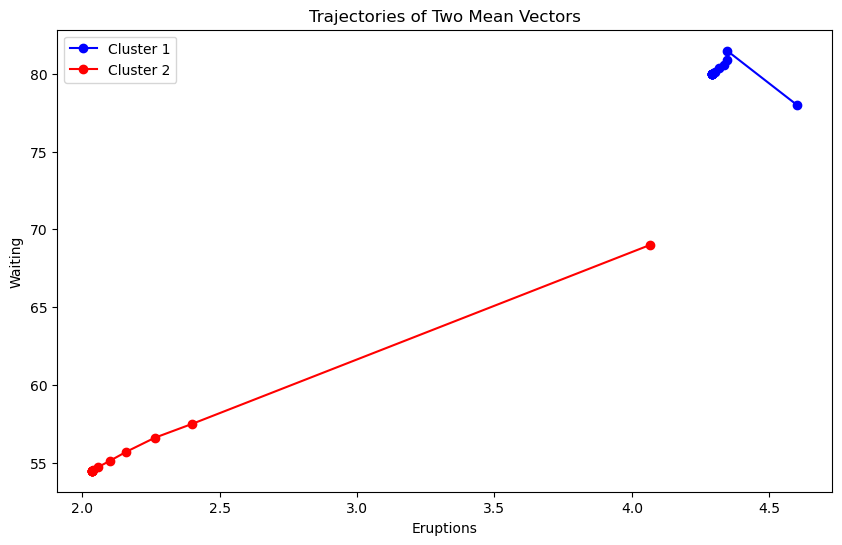

In [139]:
plt.figure(figsize=(10,6))
plt.plot(mus0_array[:,0], mus0_array[:,1], marker='o', linestyle='-', color='b', label='Cluster 1')
plt.plot(mus1_array[:,0], mus1_array[:,1], marker='o', linestyle='-', color='r', label='Cluster 2')
plt.title('Trajectories of Two Mean Vectors')
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.legend()
plt.show()

### Problem(e)


[[ 2.09433    54.75      ]
 [ 4.29793023 80.28488372]]


/Users/gareth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


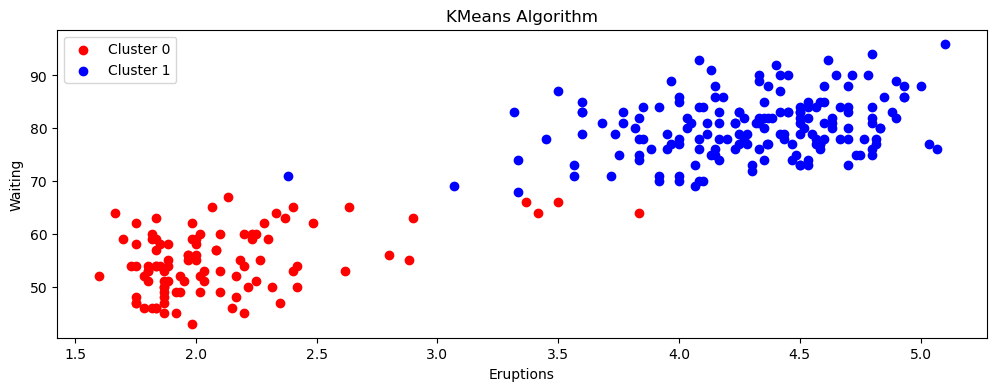

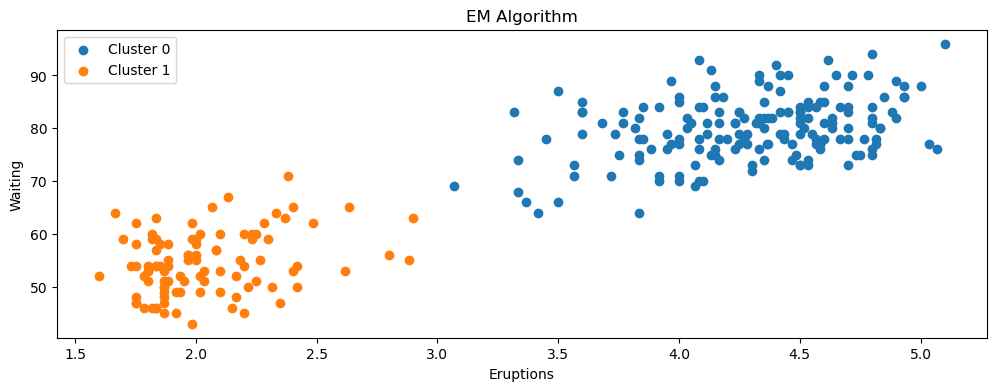

In [140]:
from sklearn.cluster import KMeans

# Kmeans 
kmeans = KMeans(n_clusters=2)  
kmeans.fit(sample_data)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
print(centers)

cluster_0_indices = np.where(labels == 0)
cluster_1_indices = np.where(labels == 1)


plt.scatter(sample_data[cluster_0_indices, 0], sample_data[cluster_0_indices, 1], color='red', label='Cluster 0')
plt.scatter(sample_data[cluster_1_indices, 0], sample_data[cluster_1_indices, 1], color='blue', label='Cluster 1')

plt.title('KMeans Algorithm')
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.legend()
plt.show()


for cluster in set(clusters):
    plt.scatter(sample_data[clusters == cluster, 0], sample_data[clusters == cluster, 1], label=f'Cluster {cluster}')

plt.title('EM Algorithm')
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.legend()
plt.show()


In EM algorithm, we find that the mean vector to be(4.29,79.97) and (2.04, 54.48).

In K-means, we find mean vectors (4.30, 80.28) and  (2.09,54.75). 

Based on the pic, we can know that the cluster is slightly different but almost the same except for a few points in the middle.

(Because these numbers have some to do with the initial parameters, the results you see in my code may not be the same as this.)

The shape of the cluster is slightly different. There are some points in the middle of these two clusters that are different in these two algorithm assignments. Because in K-means, we only consider the distance between data points and the mean center. And in the EM algorithm, we make the judgment based on the probability of different distributions. So, EM algorithm performed better on points which has similar distance to the center of clusters. In the situation of different variances and in the situation where different variables are correlated, it will perform better. 


